In [145]:
## Here are some packages and modules that you will use. Make sure they are installed.

# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for modeling 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import plotly_express as px

from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Dataframe shape: (1567, 592)
                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586

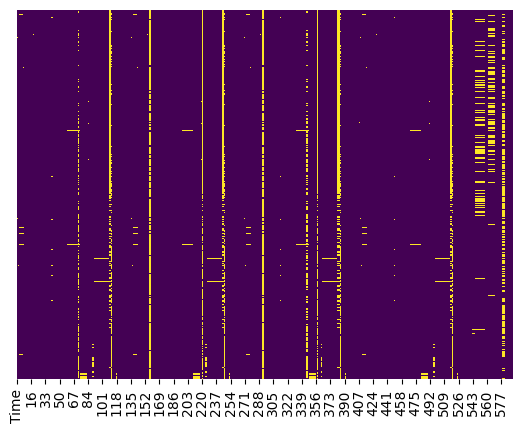

In [162]:
# Import dataset
df = pd.read_csv('uci-secom.csv') 
print("Dataframe shape:", df.shape) # Starting shape of dataset
print(df.head())

# Identify missing values and remove them
missing_values = df.isnull()
sns.heatmap(data = missing_values, yticklabels=False, cbar=False, cmap='viridis') # Visualize missing values
# df.dropna(axis=1, inplace=True) # Remove columns (axis=1) containing null values

feature_na_count = df.isna().sum() # Number of nan entries per feature
feature_na_count_hist = []
for idx, i in enumerate(df.columns): # For each feature
    for count in range(feature_na_count[idx]): # For number of missing entries
        feature_na_count_hist.append(i) # Append to histogram vector
px.histogram(data_frame=feature_na_count_hist, title="Distribution of NA Values by Feature") # Plot histogram
# px.bar(data_frame=na_count[1::], title="Histogram of NA Entries")



In [163]:
# Remove sparse features
orig_shape = df.shape # Original shape before dropping features
drop_count = 0 # Counter for number of features dropped
for idx, col in enumerate(df.columns):
    count_nan = df[col].isna().sum() # Determine number of missing entries for feature
    if count_nan > 100: # Check if feature is sparse (# missing entries > 100)
        df.drop(col, inplace=True, axis=1) # Drop feature if sparse
        drop_count += 1 # Increment drop feature counter

df.drop("Time", inplace=True, axis=1) # Drop 'Time' feature
drop_count += 1

print("# Features Dropped:", drop_count) # Output total number of features dropped
filtered_shape = df.shape 
print(filtered_shape) # Output new, filtered shape

# Features Dropped: 53
(1567, 539)


In [164]:
# Determine number of rows with missing values
row_na_count = 0

for idx, row in enumerate(df.index):
    # print(idx, ":", df.loc[[idx]].isna().sum().sum()) 
    if df.loc[idx,:].isna().sum().sum() > 0:
        row_na_count += 1
        df.drop(labels=row, inplace=True, axis=0) # Drop rows containing 1 or more missing values

    # print(df[str(row)].value_counts(dropna=False))

print("Number of data points with missing information:", row_na_count)
print("Final shape of data frame:", df.shape)


Number of data points with missing information: 174
Final shape of data frame: (1393, 539)


In [165]:
# Replace pass/fail criteria in dataset
df = df.replace(-1, 0)
print(df.iloc[:,-1]) # Verify that all pass/fail entries are 1 (pass) or 0 (fail)


1       0
2       1
3       0
4       0
5       0
       ..
1537    0
1539    0
1540    0
1541    0
1550    0
Name: Pass/Fail, Length: 1393, dtype: int64


In [166]:
# Split data
train_test_split(df, test_size = .3, random_state=42)

[            0        1          2          3       4      5         6       7  \
 1295  3089.26  2414.63  2209.8000  1175.5508  1.1464  100.0  112.1367  0.1227   
 890   3071.05  2642.15  2200.9889  1054.5240  1.3830  100.0  100.1800  0.1201   
 830   2968.33  2476.58  2216.7333  1748.0885  1.1127  100.0   97.5822  0.1242   
 323   2975.92  2286.25  2238.5444  1659.1424  0.9010  100.0   99.3100  0.1204   
 318   3033.33  2512.51  2224.0000  1510.0797  1.5611  100.0   99.8300  0.1199   
 ...       ...      ...        ...        ...     ...    ...       ...     ...   
 1183  2958.48  2611.65  2188.5111   940.2228  0.8673  100.0  105.8678  0.1232   
 1224  2975.80  2427.36  2191.8445  1093.0818  0.8725  100.0  101.4244  0.1229   
 1400  3052.98  2515.51  2172.8111   969.3436  1.2736  100.0  102.7367  0.1243   
 934   3154.13  2368.12  2189.9667  1046.6212  0.8662  100.0  102.3622  0.1208   
 1219  2952.88  2521.93  2243.8556  2209.0871  2.1422  100.0   89.4944  0.1216   
 
            8 

In [ ]:
# Implement simple machine learning model
